# Image quality check

This notebook is intended to provide a quick and simple initial check of the imaging quality to verify that it suffices our standards for the downstream analysis.

----

## 0. Environmental setup

A number of different libraries will be used for the downstream analysis, which we load hereinafter.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sys
import matplotlib.pyplot as plt
import tifffile
import scipy.ndimage as ndi

from tqdm.notebook import tqdm
from scipy import stats, signal
from skimage import measure, segmentation, filters, morphology, color, feature, exposure
from sklearn.mixture import GaussianMixture
from scipy.stats.distributions import chi2

from IPython.display import Image
from IPython.core.display import HTML 


from unidip import UniDip

sys.path.append("../..")

from src.utils.io import get_file_list
from src.utils.io import get_file_list
from src.utils.visualization import plot_3d_images_as_map, explore_slices_multichannel
from src.utils.visualization import explore_slices, explore_slices_2_samples
from src.utils.visualization import explore_slices_2_samples_multichannel, color_3d_segmentations, plot_colored_3d_segmentation



from ipyfilechooser import FileChooser
import ipywidgets as widgets


We also define a number of functions that will help us later on.

In [2]:
def load_datasets(data_dirs):
    datasets = []
    for i in tqdm(range(len(data_dirs))):
        file_names = get_file_list(data_dirs[i])
        dataset = []
        for file_name in file_names:
            dataset.append(tifffile.imread(file_name))
        datasets.append(dataset)
    return datasets


def visualize_datasets_max_z(datasets, channel_id = 0, n=5):
    n_datasets = len(datasets)
    fig, ax = plt.subplots(nrows=n_datasets, ncols=n, figsize=[20,15])
    for i in range(n_datasets):
        dataset = datasets[i]
        sample_idc = np.random.choice(len(dataset), size=n, replace=False)
        for j in range(n):
            sample = dataset[sample_idc[j]][:,channel_id].max(axis=0)
            ax[i,j].imshow(sample, cmap="seismic")
            ax[i,j].axis("off")
    return fig, ax


def visualize_datasets_2D(datasets):
    n_datasets = len(datasets)
    n = len(datasets[0])
    fig, ax = plt.subplots(nrows=n_datasets, ncols=n, figsize=[20,10])
    for i in range(n_datasets):
        dataset = datasets[i]
        for j in range(n):
            sample = dataset[j]
            ax[i,j].imshow(sample, cmap="seismic")
            ax[i,j].axis("off")
    return fig, ax

def describe_intensity_distributions(dataset, channel_id = 0):
    int_df = pd.DataFrame(columns=["int_min", "int_max", "int_range", "int_norm_mean", 
                                                        "int_norm_sd", "int_norm_median", "int_norm_q25", 
                                                       "int_norm_q75", "int_kurtosis", "int_skewness", "int_n_modes"])
    
    for i in tqdm(range(len(dataset)), desc="Compute statistics for image"):
        int_profile = dataset[i][:,channel_id].flatten()
        int_min = int_profile.min()
        int_max = int_profile.max()
        int_norm_profile = (int_profile - int_min)/(int_max-int_min)
        
        int_df.loc[i,"int_min"] = int_min
        int_df.loc[i,"int_max"] = int_max
        int_df.loc[i, "int_range"] = int_max - int_min
        int_df.loc[i,"int_norm_mean"] = int_norm_profile.mean()
        int_df.loc[i,"int_norm_sd"] = int_norm_profile.std()
        
        norm_median, norm_q25, norm_q75 = np.quantile(int_norm_profile, q=[0.5, 0.25, 0.75])
        int_df.loc[i,"int_norm_median"] = norm_median
        int_df.loc[i, "int_norm_q25"] = norm_q25
        int_df.loc[i, "int_norm_q75"] = norm_q75
        
        int_df.loc[i,"int_kurtosis"]= stats.kurtosis(int_norm_profile)
        int_df.loc[i, "int_skewness"] = stats.skew(int_norm_profile)
        
        #Identify modes as peaks of smoothed histogram (100 bins) smoothed with window length of 5
        int_df.loc[i, "int_n_modes"] = len(signal.find_peaks_cwt(np.histogram(int_norm_profile, 100)[0], [3]))
    return int_df

def describe_intensity_distributions_for_all_datasets(datasets, channel_id = 0):
    int_dfs = []
    for dataset in datasets:
        int_dfs.append(describe_intensity_distributions(dataset, channel_id))
    return int_dfs


def get_segmentation_datasets(datasets, n=10, channel=0):
    segmentation_datasets_3d = []
    segmentation_datasets_2d = []
    for dataset in datasets:
        segmentation_dataset_3d = []
        segmentation_dataset_2d = []
        n_samples = len(dataset)
        sample_idc = np.random.choice(len(dataset), size=n, replace=False)
        for idx in sample_idc:
            segmentation_dataset_2d.append(dataset[idx][:,channel].max(axis=0))
            segmentation_dataset_3d.append(dataset[idx][:,channel])
        segmentation_datasets_2d.append(segmentation_dataset_2d)
        segmentation_datasets_3d.append(segmentation_dataset_3d)
        
    return segmentation_datasets_2d, segmentation_datasets_3d
        

def segment_datasets_in_2d_by_otsu(segmentation_datasets, gamma=1, median_filter=True, fill_holes=True, closure=False):
    thresholded_datasets_2d = []
    for ds in segmentation_datasets:
        thresholded_ds = []
        for sample in ds:
            processed = sample.copy()
            if median_filter:
                processed = filters.median(sample)
            processed = exposure.adjust_gamma(processed, gamma)
            threshold = filters.threshold_otsu(processed)
            binary = processed > threshold
            if fill_holes:
                binary = ndi.binary_fill_holes(binary)
            if closure:
                binary = morphology.binary_closing(binary)
            binary = measure.label(binary)
            thresholded_ds.append(binary)
        thresholded_datasets_2d.append(thresholded_ds)
    return thresholded_datasets_2d
                
            
            


In [3]:
def visualize_dataset_statistics_as_boxplots(intensity_profile_metrics, statistic, dataset_names):
    names = []
    metrics = []
    
    for i in range(len(intensity_profile_metrics)):
        metrics.extend(list(intensity_profile_metrics[i].loc[:,statistic]))
        names.extend(list(np.repeat(dataset_names[i], len(intensity_profile_metrics[i]))))
    names = np.array(names)
    metrics = np.array(metrics)
                            
                            
    ax = sns.boxplot(x=names, y=metrics)
    ax = sns.swarmplot(x=names, y=metrics, color=".25", alpha=0.4, size=2)
    ax.set_xlabel("Datasets")
    ax.set_ylabel(statistic)
    ax.set_title("Boxplot for {}".format(statistic))
    return ax

def visualize_histograms_for_datasets(datasets, channel_id, n=5):
    n_datasets = len(datasets)
    fig, ax = plt.subplots(nrows=n_datasets, ncols=n, figsize=[20,10])
    for i in range(n_datasets):
        dataset = datasets[i]
        sample_idc = np.random.choice(len(dataset), size=n, replace=False)
        for j in range(n):
            sample = dataset[sample_idc[j]][:,channel_id]
            ax[i,j] = sns.histplot(sample.ravel(), bins=100, ax=ax[i,j])
            ax[i,j].axis("off")
            ax[i,j].set_ylim([0,500000])
    return fig, ax

def visualize_average_intensity_distribution_for_datasets(datasets, dataset_names, image_id=0, channel_id = 0, int_max = 4095):
    int_dists = []
    names = []
    for i in range(len(datasets)):
        avg_int_dist = []
        dataset = datasets[i]
        sample = dataset[image_id]
        int_dist = (list(sample[:,channel_id].ravel()))
        names.extend([dataset_names[i]]*len(int_dist))
        int_dists.extend(int_dist)
    ax = sns.kdeplot(x=int_dists, hue=names)
    #ax.set_ylim([0,500000])
    return ax

---

## 1. Read in the data

After we have loaded the required libraries, we are ready to load the imaging data whose quality we want to check. Please note that depending on the size of the imaging this might lead to an high or even overload of the memory of your system.

### 1a. Select the data locations

First, we select the locations of the data that we want to analyze.

To this end please indicate the path to your root/home directory e.g. ``/home/...`` for Unix users or ``C:/`` for Windows user.

In [7]:
home_directory = "/home/paysan_d/PycharmProjects/immune_cell_project/data/pbmc_pt/proteins/"

In [8]:
data_dirs = []

In [9]:
fc = FileChooser(home_directory)
display(fc)
fc.filter_pattern = ["*"]
fc.use_dir_icons = True

def add_data_directory(chooser):
    data_dirs.append(fc.selected)
    fc.reset()
fc.register_callback(add_data_directory)

FileChooser(path='/home/paysan_d/PycharmProjects/immune_cell_project/data/pbmc_pt/proteins', filename='', titl…

Note, that you can add multiple data locations. To this end just navigate to the respective directory and press select in the above file picker. Each directory is assumed to show data from one specific experiment, batch or replicate respectively. Please verify that you have all directories chosen that you are interested in analyzing by running the code below.

In [10]:
print("The selected file locations are: \n ", data_dirs)

The selected file locations are: 
  ['/home/paysan_d/PycharmProjects/immune_cell_project/data/pbmc_pt/proteins/timepoint_1/P11_1st point_PBMCs_Dapi_gH2AX_Lamin_28_07_21_2X_16bit_poly/raw/', '/home/paysan_d/PycharmProjects/immune_cell_project/data/pbmc_pt/proteins/timepoint_2/P11_2nd point_PBMCs_Dapi_gH2AX_Lamin_19_08_21_2X_16bit_poly/raw/', '/home/paysan_d/PycharmProjects/immune_cell_project/data/pbmc_pt/proteins/timepoint_3/P11_3rd point_PBMCs_Dapi_gH2AX_Lamin_1_09_21_2X_16bit_poly/']


In [11]:
print("Selected {} datasets.".format(len(data_dirs)))

Selected 3 datasets.


If the data locations are not correct because e.g. some were accidentally added, please rerun all code from section 1a. and again select the required locations. If there are simply some missing just add them using the file picker as before.

Finally, you may want to give names for the respective datasets that should be as short as possible. Please define them as follows:

`dataset_names = ["ds1", "ds2", "ds3", ....]`
, where you replace e.g. "ds1" with the name of your choice for the first data set. Note that each name must be separated by a comma and given in quotes.

In [12]:
dataset_names = ["p11_1", "p11_2", "p11_3"]

### 1b. Load the data into memory

Next, we will load the data of the individual data sets into memory. To this end, we expect the imaging data to be present in the previously selected directories in form of `.tif` files. Please ensure that this is the case.

In [13]:
datasets = load_datasets(data_dirs)

  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
for i in range(len(datasets)):
    print("Dataset {}: {} images were loaded.".format(dataset_names[i], len(datasets[i])))

Dataset p11_1: 47 images were loaded.
Dataset p11_2: 66 images were loaded.
Dataset p11_3: 43 images were loaded.


The above output shows you how many images were loaded. Please verify, that this is the number of images that you have for your respective datasets. Note that if there are warnings, likely one of the files is corrupted, which will have effects on the downstream analysis and should for that reason be excluded. To identify the respective file either manually inspect the imaging data or get in contact with me.

### 1c. Visualize the data

To get a first overview of the data hereinafter we can visualize some of the samples from the datasets. To this end, please indicate please indicate which channel you would like to get the max-z projections for (again indexed starting from 0, where 0 is typically the DAPI channel).

In [15]:
channel_id = 0

#### Max-z projections

First, we look at the max-z projected images to get an overall feeling of the data. Note that here already a first thing to check is that the cell(/nuclei) density is similar between different experiments especially between different replicates and batches if we are not interested in such changes.

To make the visualization not too large, we will randomly sample n=5 images from each dataset to visualize its max-z projections. Please note that this will give an error if there are not 5 different images in each of the datasets.

The n=5 randomly picked samples are shown for each dataset in separate rows.

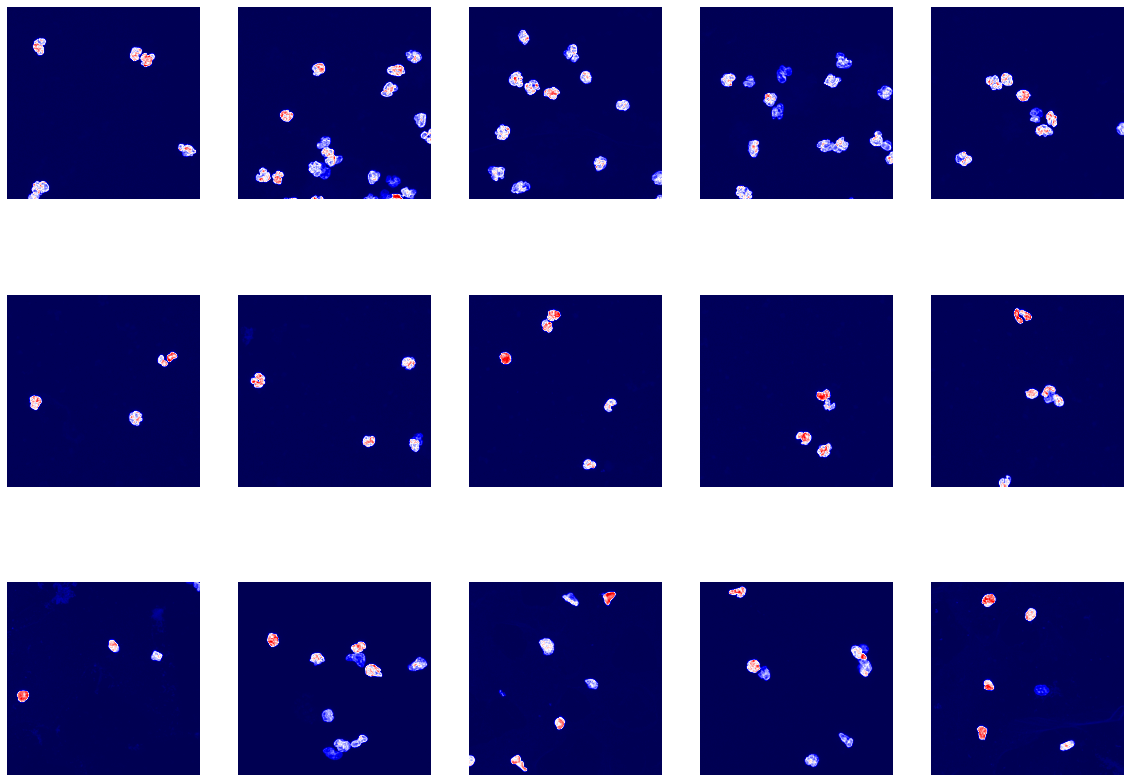

In [17]:
fig, ax = visualize_datasets_max_z(datasets[:10], channel_id=channel_id, n=5)

#### Multichannel 3D visualization.

If you want to further look at individual images you can now select the dataset ID and image ID (again the indexing starts at 0). To switch to a heat color-sheme change the `cmap` paramter to `"seismic"`.

In [18]:
dataset_id = 1
image_id = 5

explore_slices_multichannel(datasets[dataset_id][image_id], cmap="viridis")

interactive(children=(IntSlider(value=8, description='plane', max=31), IntSlider(value=0, description='channel…

<function src.utils.visualization.explore_slices_multichannel.<locals>.display_slice(plane=8, channel=0)>

---

## 2. Basic quality checks

Once, we have loaded the data we can finally start looking at some features to verify the quality of the imaging data suffices our high standards for the downstream analyses.

### 2a. Image intensity distributions

To this end, we first have to check that the intensity distributions. 

##### Intensity ranges

One thing that is important is that each image covers a sufficiently high range of the intensity spectrum for the used imaging conditions. For instance a 12bit image can assign intensity values to each pixel or voxel from 0 to 4095 for an 8 bit image it would be 0-255. To ensure that we have sufficiently signal this theoretical range should be explored as much as possible. At best the overall range of intensities is roughly the same for each image irrespective of whether or not the imaged cells come from the same population. This should be the case for all channels. The code below can be run for any channel. Please indicate the respective ID of the channel you would like to analyze.

Note that all analyses following this selection are done only for the indicated channel. To analyze a different channel, simply change the id below and rerun everything below.

In [19]:
channel_id = 0

In [20]:
intensity_profile_metrics = describe_intensity_distributions_for_all_datasets(datasets, channel_id)

Compute statistics for image:   0%|          | 0/47 [00:00<?, ?it/s]

Compute statistics for image:   0%|          | 0/66 [00:00<?, ?it/s]

Compute statistics for image:   0%|          | 0/43 [00:00<?, ?it/s]

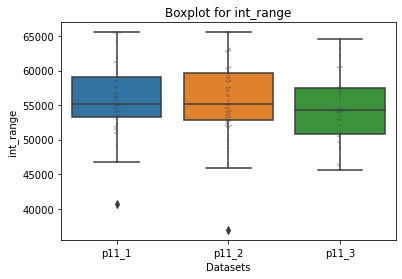

In [21]:
range_bp = visualize_dataset_statistics_as_boxplots(intensity_profile_metrics, 
                                                    statistic="int_range", 
                                                    dataset_names = dataset_names)

Note, that in an optimal setting where the full range is explored for each image in a specific dataset the respective boxplot would be simply a line at the maximum intensity value.

#### Distribution shape

The second characteristic that we would like to have for our images is that the intensity distribution are comparable between the individual samples. Hereby, the shape is more important than the scales as the latter can be easily adjusted for by normalizing the intensities. Measuring the shape of the distribution is not simple however to descriptive statistics like the skewness and the kurtosis have been often used to describe the shape of distributions. 

In general, we the image distribution should have a significant peak at the background intensity level (around e.g. around 0) and a broad spectrum there after spanning as much of the range as possible without the range coming at the cost of the image quality.

For image segmentation tasks often additionally we would like the intensity distribution to feature multiple modes, i.e. not be unimodal. This is because the first mode of the distribution will be at the background intensity values and any other mode would then describe the foreground signal that we are interested in.

For example we would like to have a bimodal distribution for e.g. DAPI staining of immune cells that show no significant heterochromatin forcai. Here, the first mode would describe the background intensities and the first mode the signal of the e.g. DNA staining

The graphic below shows an example of such a bimodal distribution.

In [22]:
Image(url= "https://www.ndt.net/article/ecndt02/412/fig2.gif",
      width=300, height=300)

To get a first idea of the intensity distribution of the individual images. Once more we will randomly visualize the histograms of n=5 image for each dataset. Note that the y-axis has been resized for a better visualization.

In [23]:
channel_id = 0

After that initial glimpse, we will now plot the distribution of the statistics describing the shapes of the distribution for the individual datasets via boxplots. To this end, we focus on the kurtosis, skewness and the number of modes as identified as peaks in the smoothed intensity histograms.

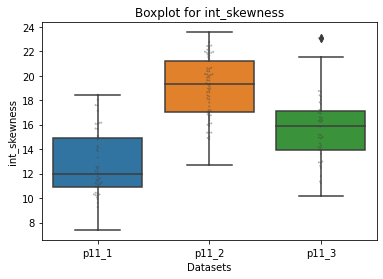

In [24]:
skew_bp = visualize_dataset_statistics_as_boxplots(intensity_profile_metrics, 
                                                    statistic="int_skewness", 
                                                    dataset_names = dataset_names)

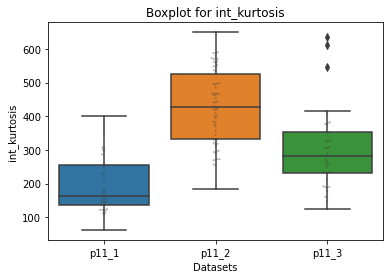

In [25]:
kurt_bp = visualize_dataset_statistics_as_boxplots(intensity_profile_metrics, 
                                                    statistic="int_kurtosis", 
                                                    dataset_names = dataset_names)

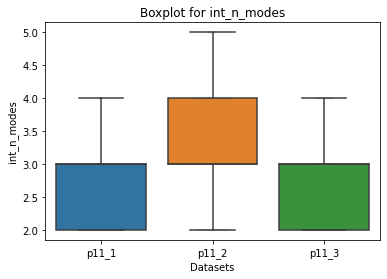

In [26]:
modes_bp = visualize_dataset_statistics_as_boxplots(intensity_profile_metrics, 
                                                    statistic="int_n_modes", 
                                                    dataset_names = dataset_names)

The above boxplots should show no signficant differences if the datasets describe the same sample conditions and should in general differ not too much. The final boxplot visualizing the number of modes of the intensity distribution should optimally only feature values larger than 0. Note that for that boxplots even dots in the boxplots representing outliers could be a problem if they are seen at values lower than 2 as for unimodal distributions separating between signal and noise will be impossible to do in a meaningful way.

#### Other distributional characteristics

Beside the shape, one could also look at further metrics discribing the scale of the distribution. To this end, one could e.g. visualize the mean or standard deviation of the normalized intensity distributions and check if that is consistent between the two datasets. The full set of possible metrics is given below.

In [27]:
set(intensity_profile_metrics[0].columns)

{'int_kurtosis',
 'int_max',
 'int_min',
 'int_n_modes',
 'int_norm_mean',
 'int_norm_median',
 'int_norm_q25',
 'int_norm_q75',
 'int_norm_sd',
 'int_range',
 'int_skewness'}

To provide another example we will here plot the distribution of the 75% percentile of the intensity distributions for the loaded datasets.

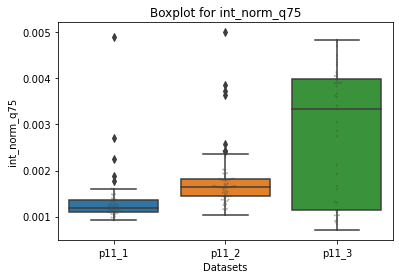

In [28]:
q75_bp = visualize_dataset_statistics_as_boxplots(intensity_profile_metrics, 
                                                    statistic="int_norm_q75", 
                                                    dataset_names = dataset_names)

Note that here between technical replicates again one should not see significant differences whereas between different experimental conditions any visible differences might be signal.

----

## 3. Segmentation

Once the image quality has been checked we can proceed with the segmentation of the nuclei. We will hereinafter provide a very simple set of procedures to segment nuclei. Note that much more sophisticated methods might be required and the tuning of the hyperparameter can be very tricky. Additionally, the segmentation can be expensive in terms of time and memory complexity. To this end, the following code should not be used to segment large quantities of images but rather to try out how easily the images can be segmented and how consistent the segmentation results are for a given set of hyperparameters for samples from different datasets, replicates aso.

### 3.1. Segmentation in 2D

First, we focus on the segmentation in 2D. The intuition is that by segmenting the cells in 2D we can already define the position of the cell in 2 dimensions which speeds up and facilitates any 3D segmentation. Note, that this holds only true if we do not want to look at object that are overlapping in 3D or touching each other. 

The segmentation will be based on simple thresholding using Otsu, where a cutoff for the intensity is computed to separate background from foreground signal. We will apply this method to the max-z projected DAPI images to segment those in 2D. Note that the intensity distribution will influence how well that segmentation does.

In the following we will first sample n=5 random samples from all datasets which we will segment to limit the time and memory complexity.

In [29]:
segmentation_datasets_2d, segmentation_datasets_3d = get_segmentation_datasets(datasets, n=10, channel=0)

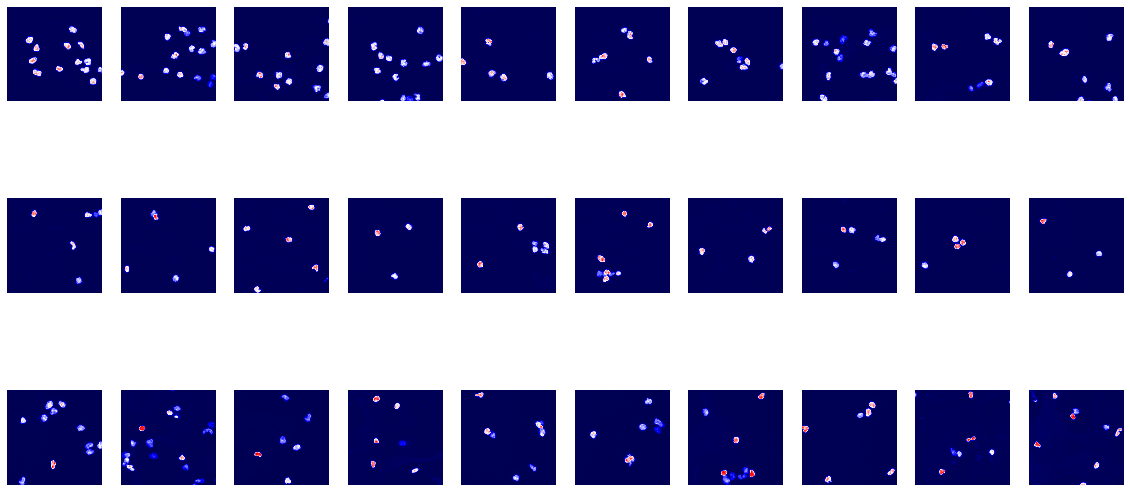

In [30]:
fig, ax = visualize_datasets_2D(segmentation_datasets_2d)

We now set a number of hyperparamters for the thresholding: `gamma` adjusts the brightness of the image (by taking the gamma-th power of the intensities), `fill holes` indicates if any holes should be closed using the connectedness of pixels, `median_filter` indicates if the image should be smoothed by a lowpass filter, `closure` indicates if the masks should be dilated and eroded to remove small holes and cracks.

In [31]:
otsu_thresholded_datasets_2d = segment_datasets_in_2d_by_otsu(segmentation_datasets_2d, gamma=0.7, 
                                                              median_filter=True, fill_holes=True, 
                                                              closure=True)

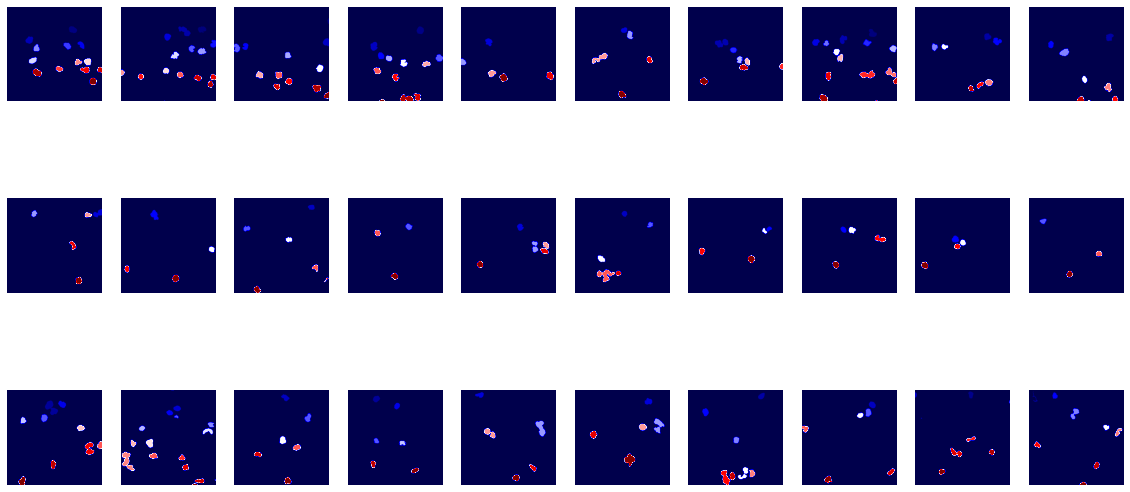

In [32]:
fig, ax = visualize_datasets_2D(otsu_thresholded_datasets_2d)

Next, objects can be labeled, quantified in 2D already and potentially filtered respectively there position in 2D used to initialize 3D segmentation.